In [1]:
import sys
sys.path.append('..')

from copy import deepcopy

import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from src.utils.data import read_and_prepare_metadata
from src.benchmarks.benchmark_factory import BenchmarkFactory
from src.scenarios.task_splitters import TaskSplitter
import src.models.torch_models as torch_models

/Users/aszarata/informatyka/magisterka/agh-continual-learning-study/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_ROOT, IMG_SIZE = "../dataset", 512

In [3]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

In [8]:
df_meta = read_and_prepare_metadata(DATASET_ROOT)
df_meta

,img_path,camera_type,pass_no,location,class,role,split,class_idx
0,train/DataSet_Xtion_RGB_train/000_Corridor1_RG...,Xtion,0,"(0.0, 0.0)",Corridor1,db,train,0
1,train/DataSet_Xtion_RGB_train/000_Corridor1_RG...,Xtion,0,"(0.0, 0.0)",Corridor1,db,train,0
2,train/DataSet_Xtion_RGB_train/001_Corridor1_RG...,Xtion,0,"(1.0, 1.0)",Corridor1,db,train,0
3,train/DataSet_Xtion_RGB_train/001_Corridor1_RG...,Xtion,0,"(1.0, 1.0)",Corridor1,db,train,0
4,train/DataSet_Xtion_RGB_train/002_Corridor1_RG...,Xtion,0,"(2.0, 2.0)",Corridor1,db,train,0
...,...,...,...,...,...,...,...,...
3301,test/DataSet_P40PRO_RGB_test3/078_F107_RGB_000...,P40PRO,3,"(878.0, 878.0)",F107,query,test,8
3302,test/DataSet_P40PRO_RGB_test3/079_F107_RGB_000...,P40PRO,3,"(879.0, 879.0)",F107,query,test,8
3303,test/DataSet_P40PRO_RGB_test3/081_F107_RGB_000...,P40PRO,3,"(881.0, 881.0)",F107,query,test,8
3304,test/DataSet_P40PRO_RGB_test3/082_F107_RGB_000...,P40PRO,3,"(882.0, 882.0)",F107,query,test,8


In [9]:
splitter = TaskSplitter(
    group_by="camera_type"
)
benchmark_factory = BenchmarkFactory(DATASET_ROOT, IMG_SIZE)

configs = splitter.split(df_meta)
benchmark = benchmark_factory.build_img_classification_benchmark(configs)

/Users/aszarata/informatyka/magisterka/agh-continual-learning-study/notebooks/../src/scenarios/task_splitters.py:36: UserWarning: you are shuffling a 'StringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_keys)


In [28]:
benchmark.streams
i = 4

In [29]:
trainset_0 = benchmark.train_stream[i].dataset
valset_0 = benchmark.valid_stream[i].dataset
testset_0 = benchmark.test_stream[i].dataset


trainloader = DataLoader(trainset_0, batch_size=16, shuffle=True)
valloader = DataLoader(valset_0, batch_size=16, shuffle=True)
testloader = DataLoader(testset_0, batch_size=16, shuffle=True)

In [11]:
def check_balance(dataset, name):
    from collections import Counter
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(label)
    
    counts = Counter(labels)
    print(f"\n{name}:")
    for cls in sorted(counts):
        print(f"  Class {cls}: {counts[cls]} ({counts[cls]/len(labels):.1%})")
    
    imbalance = max(counts.values()) / min(counts.values())
    print(f"  Imbalance ratio: {imbalance:.1f}")
    print(f"  Dataset size: {len(dataset):.1f}")

check_balance(trainset_0, "Train")
check_balance(valset_0, "Val")
check_balance(testset_0, "Test")


Train:
  Class 0: 51 (11.3%)
  Class 1: 54 (12.0%)
  Class 2: 46 (10.2%)
  Class 3: 50 (11.1%)
  Class 4: 55 (12.2%)
  Class 5: 44 (9.8%)
  Class 6: 52 (11.6%)
  Class 7: 46 (10.2%)
  Class 8: 52 (11.6%)
  Imbalance ratio: 1.2
  Dataset size: 450.0

Val:
  Class 0: 8 (8.2%)
  Class 1: 8 (8.2%)
  Class 2: 14 (14.4%)
  Class 3: 3 (3.1%)
  Class 4: 13 (13.4%)
  Class 5: 11 (11.3%)
  Class 6: 10 (10.3%)
  Class 7: 17 (17.5%)
  Class 8: 13 (13.4%)
  Imbalance ratio: 5.7
  Dataset size: 97.0

Test:
  Class 0: 9 (9.3%)
  Class 1: 4 (4.1%)
  Class 2: 8 (8.2%)
  Class 3: 15 (15.5%)
  Class 4: 11 (11.3%)
  Class 5: 18 (18.6%)
  Class 6: 5 (5.2%)
  Class 7: 16 (16.5%)
  Class 8: 11 (11.3%)
  Imbalance ratio: 4.5
  Dataset size: 97.0


In [18]:
model = torch_models.get_resnet34_for_cl(9, False)
criterion = nn.CrossEntropyLoss()
num_epochs = 40
early_stopping_patience = 5
scheduler_patience = 3
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6,)
scheduler = scheduler.ReduceLROnPlateau(optimizer, patience=scheduler_patience)

In [20]:
steps_no_progress = 0
best_val_loss = 10**10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    with tqdm(trainloader, desc="Training") as pbar:
        for (X, y) in pbar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            y_pred = model(X)
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()

            pbar.set_postfix(loss=loss.item())
            total_train_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        total_val_loss = 0.0
        with tqdm(valloader, desc="Validation") as pbar:
            for (X, y) in pbar:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                
                loss = criterion(y_pred, y)
                pbar.set_postfix(loss=loss.item())
                total_val_loss += loss.item()

                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

    train_loss = total_train_loss / len(trainloader)
    val_loss = total_val_loss / len(valloader)
    val_acc = 100 * correct / total

    steps_no_progress += 1

    if val_loss < best_val_loss:
        steps_no_progress = 0
        best_val_loss = val_loss
        best_model = deepcopy(model)

    scheduler.step(val_loss)

    print(f"Epoch: {epoch} | Train loss: {train_loss} | Val loss: {val_loss} | Val acc: {val_acc:.2f}%")
    if steps_no_progress >= early_stopping_patience:
        print("Early stop")
        break

Validation: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=2.12]


Epoch: 0 | Train loss: 2.16718151313918 | Val loss: 2.4041367053985594 | Val acc: 3.85%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=9.45]


Epoch: 1 | Train loss: 1.599706185715539 | Val loss: 9.38684253692627 | Val acc: 12.82%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=3.43]


Epoch: 2 | Train loss: 1.53902268409729 | Val loss: 3.5099470138549806 | Val acc: 33.33%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=25.1]


Epoch: 3 | Train loss: 1.2703914025000163 | Val loss: 22.996303939819335 | Val acc: 15.38%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=7.86]


Epoch: 4 | Train loss: 1.05394370002406 | Val loss: 8.903261661529541 | Val acc: 7.69%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=1.21] 


Epoch: 5 | Train loss: 0.7917410827108792 | Val loss: 0.8106581568717957 | Val acc: 69.23%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.462]


Epoch: 6 | Train loss: 0.7045936222587313 | Val loss: 0.7083677649497986 | Val acc: 75.64%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.768]


Epoch: 7 | Train loss: 0.5957847514322826 | Val loss: 0.6448321461677551 | Val acc: 79.49%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.682]


Epoch: 8 | Train loss: 0.6023848525115422 | Val loss: 0.6372695207595825 | Val acc: 74.36%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.371]


Epoch: 9 | Train loss: 0.5984169127685683 | Val loss: 0.5613492965698242 | Val acc: 85.90%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.693]


Epoch: 10 | Train loss: 0.5713890045881271 | Val loss: 0.6263146996498108 | Val acc: 80.77%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.802]


Epoch: 11 | Train loss: 0.5026800472821508 | Val loss: 0.5737219154834747 | Val acc: 82.05%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.227]


Epoch: 12 | Train loss: 0.483133393738951 | Val loss: 0.585549196600914 | Val acc: 80.77%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.485]


Epoch: 13 | Train loss: 0.4967735542782715 | Val loss: 0.5510011672973633 | Val acc: 83.33%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.327]


Epoch: 14 | Train loss: 0.44902823705758366 | Val loss: 0.5103236973285675 | Val acc: 84.62%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.348]


Epoch: 15 | Train loss: 0.424490928117718 | Val loss: 0.5583840012550354 | Val acc: 83.33%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s, loss=0.539]


Epoch: 16 | Train loss: 0.45418020790176733 | Val loss: 0.5064693450927734 | Val acc: 83.33%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.27] 


Epoch: 17 | Train loss: 0.39465545809694696 | Val loss: 0.48400182723999025 | Val acc: 84.62%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.46it/s, loss=0.396]


Epoch: 18 | Train loss: 0.42481520026922226 | Val loss: 0.5085803389549255 | Val acc: 85.90%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.571]


Epoch: 19 | Train loss: 0.4687000906893185 | Val loss: 0.4443419247865677 | Val acc: 85.90%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.317]


Epoch: 20 | Train loss: 0.3807314299046993 | Val loss: 0.4849394798278809 | Val acc: 82.05%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s, loss=0.432]


Epoch: 21 | Train loss: 0.36697967084390776 | Val loss: 0.4998082756996155 | Val acc: 85.90%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.345]


Epoch: 22 | Train loss: 0.41634515087519375 | Val loss: 0.4938217043876648 | Val acc: 84.62%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.439]


Epoch: 23 | Train loss: 0.3448142797819206 | Val loss: 0.42918062806129453 | Val acc: 88.46%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.47it/s, loss=0.22] 


Epoch: 24 | Train loss: 0.3907202551407473 | Val loss: 0.45577242970466614 | Val acc: 85.90%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s, loss=0.202]


Epoch: 25 | Train loss: 0.3594052605330944 | Val loss: 0.46664246916770935 | Val acc: 87.18%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s, loss=0.691]


Epoch: 26 | Train loss: 0.35603555185454233 | Val loss: 0.4729055404663086 | Val acc: 84.62%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s, loss=0.372]


Epoch: 27 | Train loss: 0.33362487171377453 | Val loss: 0.4885295003652573 | Val acc: 84.62%


Validation: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s, loss=0.563]

Epoch: 28 | Train loss: 0.2972405898783888 | Val loss: 0.4600228786468506 | Val acc: 84.62%
Early stop


In [ ]:
torch.save(best_model.state_dict(), "../models/ResNet34-camera-task-0-2.pth")

In [14]:
loaded_model = torch_models.get_resnet34_for_cl(9, False)
loaded_model.load_state_dict(torch.load( "../models/model_weights_exp0.pth", map_location=torch.device('cpu') ))
loaded_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

loaded_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    with tqdm(testloader, "Tests") as pbar:
        for X_test, y_test in pbar:
            X_test, y_test = X_test.to(device), y_test.to(device)
            output = loaded_model(X_test)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(y_test.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

report = classification_report(all_targets, all_preds, digits=4)
print("\nClassification Report:")
print(report)

Tests: 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

Confusion Matrix:
[[ 7  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0]
 [ 0  0  1  9  0  1  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  1]
 [ 0  0  0  0  0  2 10  1  0]
 [ 0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0 13]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         7
           1     1.0000    1.0000    1.0000        13
           2     0.9000    1.0000    0.9474         9
           3     1.0000    0.8182    0.9000        11
           4     1.0000    1.0000    1.0000        12
           5     0.7857    0.9167    0.8462        12
           6     1.0000    0.7692    0.8696        13
           7     0.9167    1.0000    0.9565        11
           8     0.9286    1.0000    0.9630        13

    accuracy                         0.9406       101
   macro avg     0.9479    0.9449    0.9425       101
weighted avg     0.9474    0.9406    

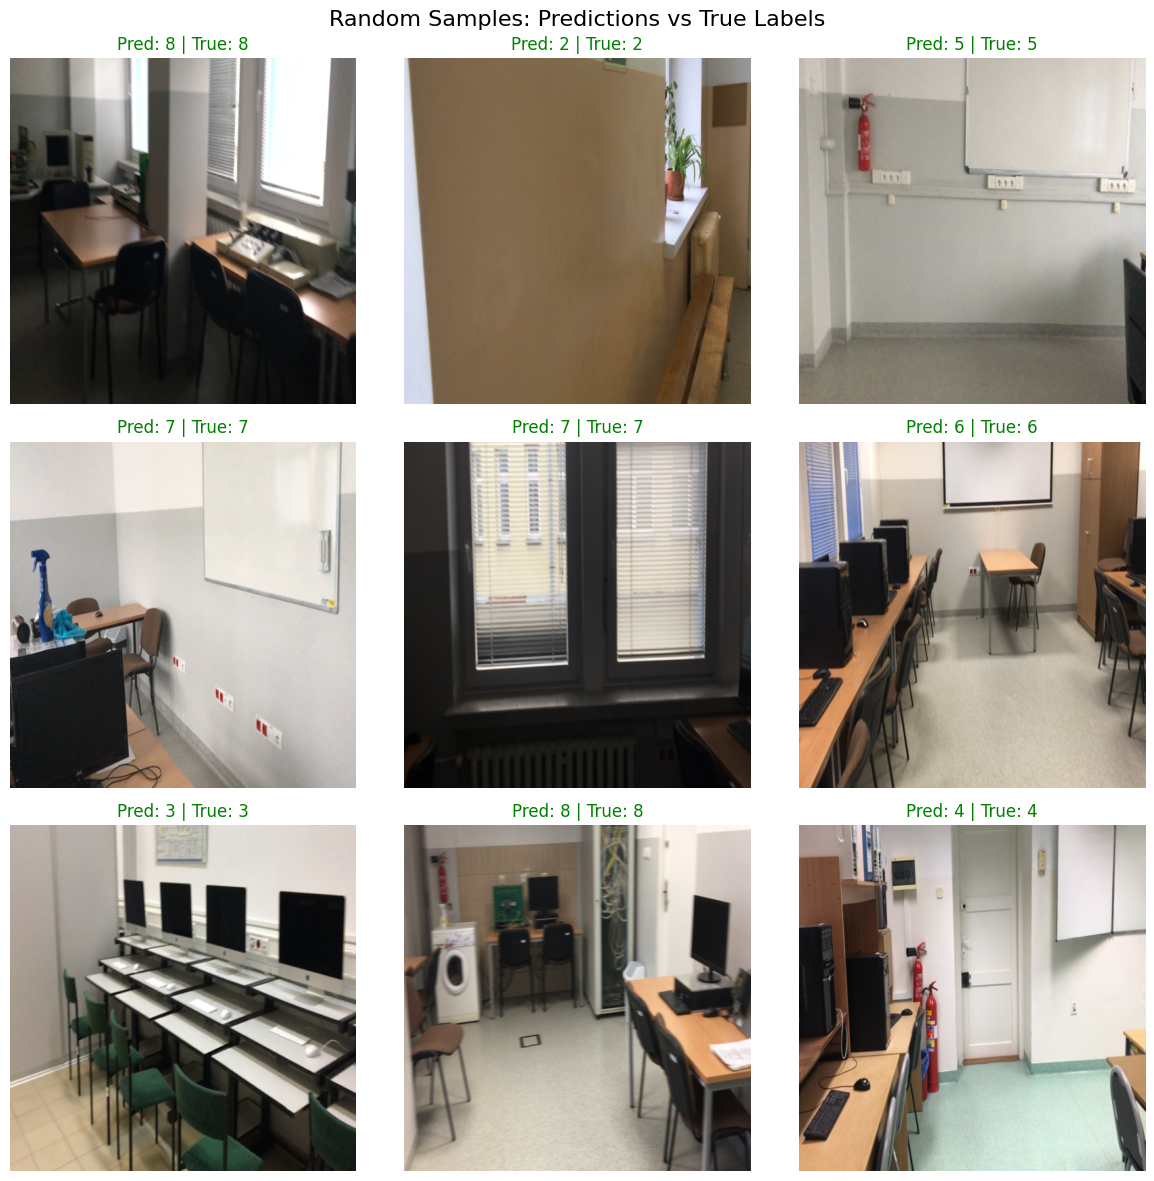

Evaluated 9 random samples:
Correct predictions: 7


In [37]:
import matplotlib.pyplot as plt
import random

sample_indices = random.sample(range(len(testloader.dataset)), 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Random Samples: Predictions vs True Labels', fontsize=16)

loaded_model.eval()

for idx, ax in enumerate(axes.flat):
    data_idx = sample_indices[idx]
    sample, true_label = testloader.dataset[data_idx]
 
    with torch.no_grad():
        sample_tensor = sample.unsqueeze(0).to(device)
        output = loaded_model(sample_tensor)
        pred = output.argmax(dim=1).item()

    if sample.dim() == 3: 
        sample_np = sample.permute(1, 2, 0).cpu().numpy()
        if sample_np.shape[2] == 1: 
            sample_np = sample_np.squeeze()
        ax.imshow(sample_np, cmap='gray' if sample_np.ndim == 2 else None)
    else:
        ax.text(0.5, 0.5, f"Sample {data_idx}", 
                ha='center', va='center', fontsize=12)

    title_color = 'green' if pred == true_label else 'red'
    ax.set_title(f"Pred: {pred} | True: {true_label}", 
                 color=title_color, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Evaluated {len(sample_indices)} random samples:")
print(f"Correct predictions: {sum(1 for i in range(9) if 
      (torch.tensor(all_preds[sample_indices[i]]) == torch.tensor(all_targets[sample_indices[i]])).item())}")